In [1]:
# %load common.py
"""Mixture model for collaborative filtering"""
from typing import NamedTuple, Tuple
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Arc


class GaussianMixture(NamedTuple):
    """Tuple holding a gaussian mixture"""
    mu: np.ndarray  # (K, d) array - each row corresponds to a gaussian component mean
    var: np.ndarray  # (K, ) array - each row corresponds to the variance of a component
    p: np.ndarray  # (K, ) array = each row corresponds to the weight of a component


def init(X: np.ndarray, K: int,
         seed: int = 0) -> Tuple[GaussianMixture, np.ndarray]:
    """Initializes the mixture model with random points as initial
    means and uniform assingments

    Args:
        X: (n, d) array holding the data
        K: number of components
        seed: random seed

    Returns:
        mixture: the initialized gaussian mixture
        post: (n, K) array holding the soft counts
            for all components for all examples

    """
    np.random.seed(seed)
    n, _ = X.shape
    p = np.ones(K) / K

    # select K random points as initial means
    mu = X[np.random.choice(n, K, replace=False)]
    var = np.zeros(K)
    # Compute variance
    for j in range(K):
        var[j] = ((X - mu[j])**2).mean()

    mixture = GaussianMixture(mu, var, p)
    post = np.ones((n, K)) / K

    return mixture, post


def plot(X: np.ndarray, mixture: GaussianMixture, post: np.ndarray,
         title: str):
    """Plots the mixture model for 2D data"""
    _, K = post.shape

    percent = post / post.sum(axis=1).reshape(-1, 1)
    fig, ax = plt.subplots()
    ax.title.set_text(title)
    ax.set_xlim((-20, 20))
    ax.set_ylim((-20, 20))
    r = 0.25
    color = ["r", "b", "k", "y", "m", "c"]
    for i, point in enumerate(X):
        theta = 0
        for j in range(K):
            offset = percent[i, j] * 360
            arc = Arc(point,
                      r,
                      r,
                      0,
                      theta,
                      theta + offset,
                      edgecolor=color[j])
            ax.add_patch(arc)
            theta += offset
    for j in range(K):
        mu = mixture.mu[j]
        sigma = np.sqrt(mixture.var[j])
        circle = Circle(mu, sigma, color=color[j], fill=False)
        ax.add_patch(circle)
        legend = "mu = ({:0.2f}, {:0.2f})\n stdv = {:0.2f}".format(
            mu[0], mu[1], sigma)
        ax.text(mu[0], mu[1], legend)
    plt.axis('equal')
    plt.show()


def rmse(X, Y):
    return np.sqrt(np.mean((X - Y)**2))

def bic(X: np.ndarray, mixture: GaussianMixture,
        log_likelihood: float) -> float:
    """Computes the Bayesian Information Criterion for a
    mixture of gaussians

    Args:
        X: (n, d) array holding the data
        mixture: a mixture of spherical gaussian
        log_likelihood: the log-likelihood of the data

    Returns:
        float: the BIC for this mixture
    """
    # Number of examples
    n = X.shape[0]
    
    # Number of adjustable params = total params - 1 (last prob = 1 - sum(other probs))
    p = 0
    for i in range(len(mixture)):
        if i == 0:
            p += mixture[i].shape[0] * mixture[i].shape[1]  # For means: K times d
        else:
            p += mixture[i].shape[0]    # Other params: just add K
    p = p - 1
    
    # BIC: log_lh - (1/2)*p*log(n)
    bic = log_likelihood - (p*np.log(n))/2.0
    
    return bic


In [2]:
# %load em.py
"""Mixture model for matrix completion"""
from typing import Tuple
import numpy as np
from scipy.special import logsumexp
from common import GaussianMixture


def estep(X: np.ndarray, mixture: GaussianMixture) -> Tuple[np.ndarray, float]:
    """E-step: Softly assigns each datapoint to a gaussian component

    Args:
        X: (n, d) array holding the data, with incomplete entries (set to 0)
        mixture: the current gaussian mixture

    Returns:
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the assignment

    """
    n, d = X.shape
    mu, var, pi = mixture   # Unpack mixture tuple
    K = mu.shape[0]
    
######## Loop version to calculate norms: 2nd fastest ########
    
    # f(u,j) matrix that's used to store the normal matrix and log of posterior probs: (p(j|u))
#    f = np.zeros((n,K), dtype=np.float64)
#    
#    # Compute the normal matrix: Single loop implementation
#    for i in range(n):
#        # For each user pick only columns that have ratings
#        Cu_indices = X[i,:] != 0
#        # Dimension of Cu (no. of non-zero entries)
#        dim = np.sum(Cu_indices)
#        # log of pre-exponent for this user's gaussian dist.
#        pre_exp = (-dim/2.0)*np.log((2*np.pi*var))
#        # Calculate the exponent term of the gaussian
#        diff = X[i, Cu_indices] - mu[:, Cu_indices]    # This will be (K,|Cu|)
#        norm = np.sum(diff**2, axis=1)  # This will be (K,)
#        
#        # Now onto the final log normal matrix: log(N(...))
#        # We will need log(normal), exp will cancel, so no need to calculate it
#        f[i,:] = pre_exp - norm/(2*var)  # This is the ith users log gaussian dist vector: (K,)
    
######## End: loop version ########
    
######## Vectorized version to calculate norms ########
    
    # Create a delta matrix to indicate where X is non-zero, which will help us pick Cu indices
    delta = X.astype(bool).astype(int)
    # Exponent term: norm matrix/(2*variance)
#    f = np.sum(((X[:, None, :] - mu)*delta[:, None, :])**2, axis=2)/(2*var) # This is using 3D broadcasting: slowest of all
    f = (np.sum(X**2, axis=1)[:,None] + (delta @ mu.T**2) - 2*(X @ mu.T))/(2*var) # This is using indicator matrix: fastest of all
    # Pre-exponent term: A matrix of shape (n, K)
    pre_exp = (-np.sum(delta, axis=1).reshape(-1,1)/2.0) @ (np.log((2*np.pi*var)).reshape(-1,1)).T
    # Put them together
    f = pre_exp - f
    
######## End: vectorized version ########
    
    f = f + np.log(pi + 1e-16)  # This is the f(u,j) matrix
    
    # log of normalizing term in p(j|u)
    logsums = logsumexp(f, axis=1).reshape(-1,1)  # Store this to calculate log_lh
    log_posts = f - logsums # This is the log of posterior prob. matrix: log(p(j|u))
    
    log_lh = np.sum(logsums, axis=0).item()   # This is the log likelihood
    
    return np.exp(log_posts), log_lh


def mstep(X: np.ndarray, post: np.ndarray, mixture: GaussianMixture,
          min_variance: float = .25) -> GaussianMixture:
    """M-step: Updates the gaussian mixture by maximizing the log-likelihood
    of the weighted dataset

    Args:
        X: (n, d) array holding the data, with incomplete entries (set to 0)
        post: (n, K) array holding the soft counts
            for all components for all examples
        mixture: the current gaussian mixture
        min_variance: the minimum variance for each gaussian

    Returns:
        GaussianMixture: the new gaussian mixture
    """
    n, d = X.shape
    mu_rev, _, _ = mixture
    K = mu_rev.shape[0]
    
    # Calculate revised pi(j): same expression as in the naive case
    pi_rev = np.sum(post, axis=0)/n
    
    # Create delta matrix indicating where X is non-zero
    delta = X.astype(bool).astype(int)
    
    # Update means only when sum_u(p(j|u)*delta(l,Cu)) >= 1
    denom = post.T @ delta # Denominator (K,d): Only include dims that have information
    numer = post.T @ X  # Numerator (K,d)
    update_indices = np.where(denom >= 1)   # Indices for update
    mu_rev[update_indices] = numer[update_indices]/denom[update_indices] # Only update where necessary (denom>=1)
    
    # Update variances
    denom_var = np.sum(post*np.sum(delta, axis=1).reshape(-1,1), axis=0) # Shape: (K,)
    
######## Loop version for norms calc. ##########
    
    # Norm matrix for variance calc
#    norms = np.zeros((n, K), dtype=np.float64)
#    
#    for i in range(n):
#        # For each user pick only columns that have ratings
#        Cu_indices = X[i,:] != 0
#        diff = X[i, Cu_indices] - mu_rev[:, Cu_indices]    # This will be (K,|Cu|)
#        norms[i,:] = np.sum(diff**2, axis=1)  # This will be (K,)
    
######## End: loop version #########
        
######## Vectorized version for norms calc. ########
    
#    norms = np.sum(((X[:, None, :] - mu_rev)*delta[:, None, :])**2, axis=2)
    norms = np.sum(X**2, axis=1)[:,None] + (delta @ mu_rev.T**2) - 2*(X @ mu_rev.T)
    
######## End: vectorized version #########
    
    # Revised var: if var(j) < 0.25, set it = 0.25
    var_rev = np.maximum(np.sum(post*norms, axis=0)/denom_var, min_variance)  
    
    return GaussianMixture(mu_rev, var_rev, pi_rev)

def run(X: np.ndarray, mixture: GaussianMixture,
        post: np.ndarray) -> Tuple[GaussianMixture, np.ndarray, float]:
    """Runs the mixture model

    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the current assignment
    """
    old_log_lh = None
    new_log_lh = None  # Keep track of log likelihood to check convergence
    
    # Start the main loop
    while old_log_lh is None or (new_log_lh - old_log_lh > 1e-6*np.abs(new_log_lh)):
        
        old_log_lh = new_log_lh
        
        # E-step
        post, new_log_lh = estep(X, mixture)
        
        # M-step
        mixture = mstep(X, post, mixture)
            
    return mixture, post, new_log_lh


def fill_matrix(X: np.ndarray, mixture: GaussianMixture) -> np.ndarray:
    """Fills an incomplete matrix according to a mixture model

    Args:
        X: (n, d) array of incomplete data (incomplete entries =0)
        mixture: a mixture of gaussians

    Returns
        np.ndarray: a (n, d) array with completed data
    """
    X_pred = X.copy()
    mu, _, _ = mixture
    
    post, _ = estep(X, mixture)
    
    # Missing entries to be filled
    miss_indices = np.where(X == 0)
    X_pred[miss_indices] = (post @ mu)[miss_indices]
    
    return X_pred


In [3]:
# %load kmeans.py
"""Mixture model based on kmeans"""
from typing import Tuple
import numpy as np
from common import GaussianMixture


def estep(X: np.ndarray, mixture: GaussianMixture) -> np.ndarray:
    """E-step: Assigns each datapoint to the gaussian component with the
    closest mean

    Args:
        X: (n, d) array holding the data
        mixture: the current gaussian mixture

    Returns:
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples

        """
    n, _ = X.shape
    K, _ = mixture.mu.shape
    post = np.zeros((n, K))

    for i in range(n):
        tiled_vector = np.tile(X[i, :], (K, 1))
        sse = ((tiled_vector - mixture.mu)**2).sum(axis=1)
        j = np.argmin(sse)
        post[i, j] = 1

    return post


def mstep(X: np.ndarray, post: np.ndarray) -> Tuple[GaussianMixture, float]:
    """M-step: Updates the gaussian mixture. Each cluster
    yields a component mean and variance.

    Args: X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
        float: the distortion cost for the current assignment
    """
    n, d = X.shape
    _, K = post.shape

    n_hat = post.sum(axis=0)
    p = n_hat / n

    cost = 0
    mu = np.zeros((K, d))
    var = np.zeros(K)

    for j in range(K):
        mu[j, :] = post[:, j] @ X / n_hat[j]
        sse = ((mu[j] - X)**2).sum(axis=1) @ post[:, j]
        cost += sse
        var[j] = sse / (d * n_hat[j])

    return GaussianMixture(mu, var, p), cost


def run(X: np.ndarray, mixture: GaussianMixture,
        post: np.ndarray) -> Tuple[GaussianMixture, np.ndarray, float]:
    """Runs the mixture model

    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: distortion cost of the current assignment
    """

    prev_cost = None
    cost = None
    while (prev_cost is None or prev_cost - cost > 1e-4):
        prev_cost = cost
        post = estep(X, mixture)
        mixture, cost = mstep(X, post)

    return mixture, post, cost


=============== Clusters: 1 ======================
Lowest cost using kMeans is: 5462.297452340001
Highest log likelihood using EM is: -1307.2234317600935


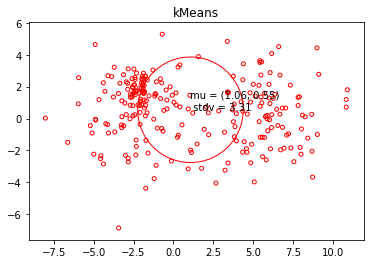

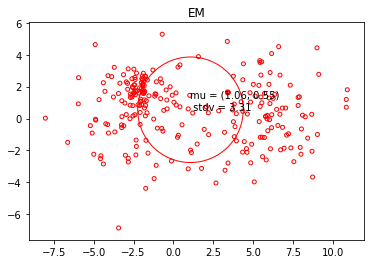

=============== Clusters: 2 ======================
Lowest cost using kMeans is: 1684.9079502962372
Highest log likelihood using EM is: -1175.7146293666797


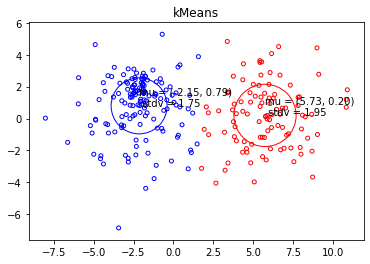

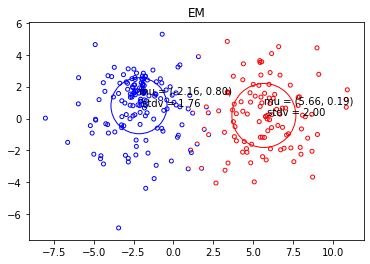

=============== Clusters: 3 ======================
Lowest cost using kMeans is: 1329.5948671544297
Highest log likelihood using EM is: -1138.890899687267


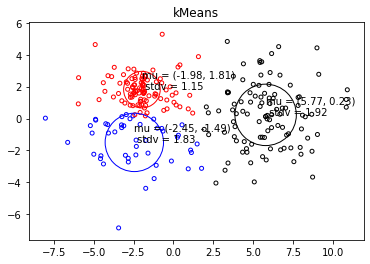

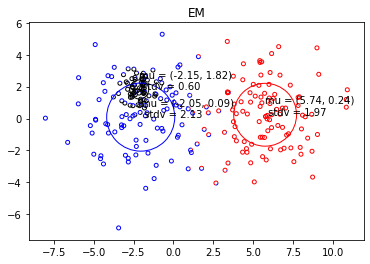

=============== Clusters: 4 ======================
Lowest cost using kMeans is: 1035.499826539466
Highest log likelihood using EM is: -1138.601175699485


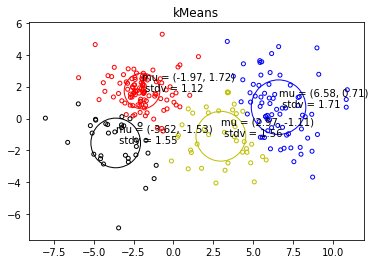

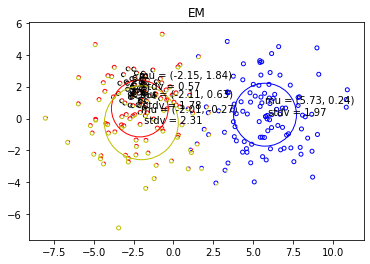

================= BIC ====================
Best K is: 3
BIC for the best K is: -1169.2589347355092


In [4]:
# %load main.py
import numpy as np
import kmeans
import common
import naive_em
import em

X = np.loadtxt("toy_data.txt")

########## Begin: kMeans vs EM (and BIC) #############
K = [1, 2, 3, 4]    # Clusters to try
seeds = [0, 1, 2, 3, 4]     # Seeds to try

# Costs for diff. seeds
costs_kMeans = [0, 0, 0, 0, 0]
costs_EM = [0, 0, 0, 0, 0]

# Best seed for cluster based on lowest costs 
best_seed_kMeans = [0, 0, 0, 0]
best_seed_EM = [0, 0, 0, 0]

# Mixtures for best seeds
mixtures_kMeans = [0, 0, 0, 0, 0]
mixtures_EM = [0, 0, 0, 0, 0]

# Posterior probs. for best seeds
posts_kMeans = [0, 0, 0, 0, 0]
posts_EM = [0, 0, 0, 0, 0]

# BIC score of cluster
bic = [0., 0., 0., 0.]

for k in range(len(K)):
    for i in range(len(seeds)):
        
        # Run kMeans
        mixtures_kMeans[i], posts_kMeans[i], costs_kMeans[i] = \
        kmeans.run(X, *common.init(X, K[k], seeds[i]))
        
        # Run Naive EM
        mixtures_EM[i], posts_EM[i], costs_EM[i] = \
        naive_em.run(X, *common.init(X, K[k], seeds[i]))
    
    # Print lowest cost
    print("=============== Clusters:", k+1, "======================")
    print("Lowest cost using kMeans is:", np.min(costs_kMeans))
    print("Highest log likelihood using EM is:", np.max(costs_EM))
    
    # Save best seed for plotting
    best_seed_kMeans[k] = np.argmin(costs_kMeans)
    best_seed_EM[k] = np.argmax(costs_EM) 
    
    # Plot kMeans and EM results
    common.plot(X, 
                mixtures_kMeans[best_seed_kMeans[k]], 
                posts_kMeans[best_seed_kMeans[k]], 
                title="kMeans")

    common.plot(X, 
                mixtures_EM[best_seed_EM[k]], 
                posts_EM[best_seed_EM[k]], 
                title="EM") 
    
    #BIC score for EM
    bic[k] = common.bic(X, mixtures_EM[best_seed_EM[k]], np.max(costs_EM))
    
# Print the best K based on BIC
print("================= BIC ====================")
print("Best K is:", np.argmax(bic)+1)
print("BIC for the best K is:", np.max(bic))
 
########## End: kMeans vs EM (and BIC) #############

In [5]:
# %load naive_em.py
"""Mixture model using EM"""
from typing import Tuple
import numpy as np
from common import GaussianMixture



def estep(X: np.ndarray, mixture: GaussianMixture) -> Tuple[np.ndarray, float]:
    """E-step: Softly assigns each datapoint to a gaussian component

    Args:
        X: (n, d) array holding the data
        mixture: the current gaussian mixture

    Returns:
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the assignment
    """
    n, d = X.shape
    mu, var, pi = mixture  # Unpack mixture tuple
    K = mu.shape[0]
    
    # Compute normal dist. matrix: (N, K)
    pre_exp = (2*np.pi*var)**(d/2)
    
    # Calc exponent term: norm matrix/(2*variance)
    post = np.linalg.norm(X[:,None] - mu, ord=2, axis=2)**2   # Vectorized version
    post = np.exp(-post/(2*var))
    
#    post = np.zeros((n, K), dtype=np.float64) # For loop version: Array to hold posterior probs and normal matrix
#    for i in range(n):  # Use single loop to complete Normal matrix: faster than broadcasting in 3D
#        dist = X[i,:] - mu     # Compute difference: will be (K,d) for each n
#        norm = np.sum(dist**2, axis=1)  # Norm: will be (K,) for each n
#        post[i,:] = np.exp(-norm/(2*var))   # This is the exponent term of normal
    
    post = post/pre_exp     # Final Normal matrix: will be (n, K)

    numerator = post*pi
    denominator = np.sum(numerator, axis=1).reshape(-1,1) # This is the vector p(x;theta)
 
    post = numerator/denominator    # This is the matrix of posterior probs p(j|i)
    
    log_lh = np.sum(np.log(denominator), axis=0).item()    # Log-likelihood
    
    return post, log_lh

def mstep(X: np.ndarray, post: np.ndarray) -> GaussianMixture:
    """M-step: Updates the gaussian mixture by maximizing the log-likelihood
    of the weighted dataset

    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
    """
    n, d = X.shape
    K = post.shape[1]
    
    nj = np.sum(post, axis=0)   # shape is (K, )
    
    pi = nj/n   # Cluster probs; shape is (K, )
    
    mu = (post.T @ X)/nj.reshape(-1,1)  # Revised means; shape is (K,d)
    
    norms = np.linalg.norm(X[:, None] - mu, ord=2, axis=2)**2    # Vectorized version

#    norms = np.zeros((n, K), dtype=np.float64) # For loopy version: Matrix to hold all the norms: (n,K)
#    for i in range(n):
#        dist = X[i,:] - mu
#        norms[i,:] = np.sum(dist**2, axis=1)
        
    var = np.sum(post*norms, axis=0)/(nj*d)     # Revised variance; shape is (K, )
    
    return GaussianMixture(mu, var, pi)

def run(X: np.ndarray, mixture: GaussianMixture,
        post: np.ndarray) -> Tuple[GaussianMixture, np.ndarray, float]:
    """Runs the mixture model

    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the current assignment
    """
    
    old_log_lh = None
    new_log_lh = None  # Keep track of log likelihood to check convergence
    
    # Start the main loop
    while old_log_lh is None or (new_log_lh - old_log_lh > 1e-6*np.abs(new_log_lh)):
        
        old_log_lh = new_log_lh
        
        # E-step
        post, new_log_lh = estep(X, mixture)
        
        # M-step
        mixture = mstep(X, post)
            
    return mixture, post, new_log_lh

In [7]:
# %load test.py
import numpy as np
import em
import common

#%% Testing implementation of EM algorithm
X = np.loadtxt("test_incomplete.txt")
X_gold = np.loadtxt("test_complete.txt")

n, d = X.shape

K = 4
seed = 0

mix_conv, post_conv, log_lh_conv = em.run(X, *common.init(X, K, seed))

X_predict = em.fill_matrix(X, mix_conv)

rmse = common.rmse(X_gold, X_predict)

#%% Begin: Comparison of EM for matrix completion with K = 1 and 12
import time

X = np.loadtxt("netflix_incomplete.txt")
X_gold = np.loadtxt("netflix_complete.txt")

K = [1, 12]    # Clusters to try

log_lh = [0, 0, 0, 0, 0]    # Log likelihoods for different seeds

# Best seed for cluster based on highest log likelihoods
best_seed = [0, 0]

# Mixtures for best seeds
mixtures = [0, 0, 0, 0, 0]

# Posterior probs. for best seeds
posts = [0, 0, 0, 0, 0]

# RMS Error for clusters
rmse = [0., 0.]

start_time = time.perf_counter()

for k in range(len(K)):
    for i in range(5):
        
        # Run EM
        mixtures[i], posts[i], log_lh[i] = \
        em.run(X, *common.init(X, K[k], i))
    
    # Print lowest cost
    print("=============== Clusters:", K[k], "======================")
    print("Highest log likelihood using EM is:", np.max(log_lh))
    
    # Save best seed for plotting
    best_seed[k] = np.argmax(log_lh)
    
    # Use the best mixture to fill prediction matrix
    X_pred = em.fill_matrix(X, mixtures[best_seed[k]])
    rmse[k] = common.rmse(X_gold, X_pred)

print("===================================================")
print("RMS Error for K = 12 is: {:.4f}".format(rmse[1]))
end_time = time.perf_counter()
print("Time taken for this run: {:.4f} seconds".format(end_time - start_time))

=============== Clusters: 1 ======================
Highest log likelihood using EM is: -1521060.953985246
=============== Clusters: 12 ======================
Highest log likelihood using EM is: -1390234.4223469382
RMS Error for K = 12 is: 0.4805
Time taken for this run: 2.2284 seconds
